In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF, Matern

In [2]:
from src.config import *
from src.utils import per_error
from src.load_dataset import load_dataset
from src.load_models import select_model

/Users/sangam/Desktop/Epilepsey/Code/vgramreg/src/load_dataset.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"PH": 'univariate, max(S)', 'signal_std':'univariate, std(S)', 'signal_mean':'univariate, mean(S)', 'peak area':'univariate, area(S)', \


[ 3.53515238e+00  8.54187605e+01  1.04138027e+00  1.04299320e+00
  5.41466612e-02  5.04761905e-03  1.32197279e-02  1.23252993e+00
 -1.36619728e+00  2.59872993e+00  1.01115646e+00  1.06908844e+00
  1.08291156e-01]
######Data Distribution:#########
Training {0: 50, 16: 50, 8: 47}
Testing {0: 34, 8: 31, 16: 34}
#################################


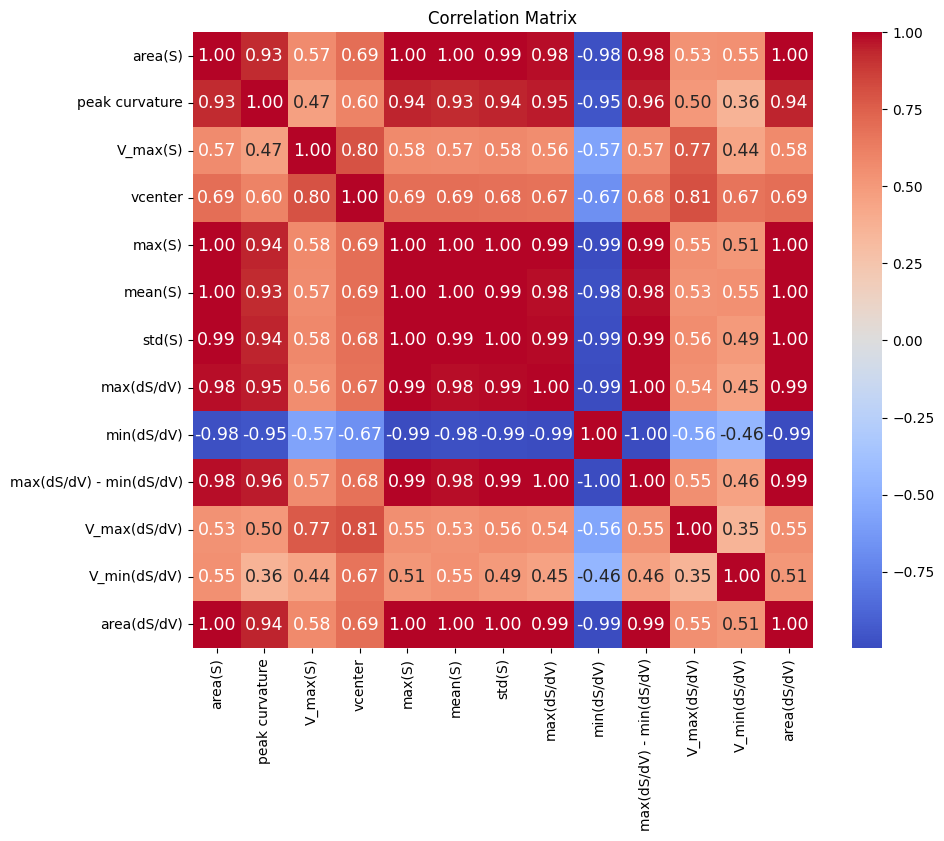

In [3]:
# Load Training Dataset
X_train, X_test, y_train, y_test = load_dataset()

In [4]:
X_train

array([[-1.12488495, -0.8739449 ,  0.08781109, ..., -1.47132408,
        -0.44142635, -1.12964941],
       [ 1.23879357,  1.28391871,  0.63578489, ...,  0.71061428,
         0.50291402,  1.30741512],
       [-1.15971178, -0.5035818 , -1.41458065, ..., -2.28955096,
        -0.84614366, -1.15032312],
       ...,
       [-0.48090794, -0.3831776 ,  0.57046351, ...,  0.16512969,
         0.90763132, -0.46687488],
       [-1.13889833, -1.25450828, -1.36377514, ..., -1.88043752,
        -0.17161482, -1.14059431],
       [ 0.24560903,  0.07849153,  1.02408421, ...,  0.98335657,
         1.04253709,  0.24575976]])

In [4]:
# Convert the custom error function to a scorer
def per_error(y_test, y_pred)->float:
    y_LOD=1.6193237802284837
   
    mask           = (y_test != 0)    # Non Zero Concentration
    zero_mask      = ~(mask)          # Zero Concentration

    y_pred         = np.maximum(y_pred, 0.0)

    # Only for non zero concentration
    non_zero_per_error = np.abs(y_test[mask] - y_pred[mask])/(0.5*(y_test[mask] + y_pred[mask]))
   
    # zero concentration
    zero_per_error     = np.abs(y_test[zero_mask] - y_pred[zero_mask]) / y_LOD

    # assert not(np.isnan(zero_per_error).any())
    # assert not(np.isnan(non_zero_per_error).any())

    per_error         = np.concatenate((non_zero_per_error, zero_per_error))
    per_error         = np.mean(per_error) * 100

    return per_error
    


In [10]:
models = ['GP']
metric = 'per_error'

# r2_features = { 'SVM': ['univariate, std(S)', 'peak curvature', 'univariate, V_max(dS/dV)', 'univariate, max(dS/dV)', 'univariate, V_max(S)'],
#                 'RF' : ['univariate, std(S)', 'univariate, max(S)', 'univariate, min(dS/dV)'],
#                 'KNN': ['univariate, area(S)', 'univariate, V_max(S)', 'univariate, min(dS/dV)', 'univariate, std(S)'],
#                 'GP' : ['univariate, V_max(dS/dV)'],
#                 'Lasso': ['univariate, std(S)', 'univariate, V_max(S)', 'univariate, min(dS/dV)', 'univariate, V_max(dS/dV)', 'peak curvature'],
#                 'Ridge': ['univariate, std(S)', 'univariate, V_max(S)', 'univariate, min(dS/dV)', 'univariate, V_max(dS/dV)', 'peak curvature']
#               }
# per_error_features = { 'SVM': ['univariate, area(dS/dV)', 'univariate, max(dS/dV) - min(dS/dV)', 'univariate, V_max(dS/dV)', 'univariate, V_max(S)', 'univariate, std(S)', 'univariate, max(S)', 'univariate, min(dS/dV)', 'univariate, area(S)', 'univariate, max(dS/dV)', 'univariate, mean(S)'],
#                 'RF' : ['univariate, std(S)', 'univariate, max(dS/dV) - min(dS/dV)', 'univariate, max(S)'],
#                 'KNN': ['univariate, std(S)', 'univariate, area(dS/dV)'],
#                 'GP' : ['univariate, V_max(dS/dV)'],
#                 'Lasso': ['univariate, std(S)', 'vcenter', 'univariate, area(dS/dV)', 'univariate, V_max(S)', 'peak curvature', 'univariate, V_max(dS/dV)', 'univariate, V_min(dS/dV)', 'univariate, max(dS/dV)', 'univariate, max(S)'],
#                 'Ridge': ['univariate, std(S)', 'vcenter', 'univariate, area(dS/dV)', 'peak curvature', 'univariate, V_max(dS/dV)', 'univariate, V_min(dS/dV)', 'univariate, max(dS/dV) - min(dS/dV)', 'univariate, V_max(S)', 'univariate, max(S)']      
#                      }
              
# Define the parameter grid
# Define the parameter grid
param_grids = {'SVM':{
                    'C': [1, 10, 15, 20, 100],
                    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                    'kernel': ['rbf']},
              
              'RF': {
                    'n_estimators': [80, 90, 100, 110, 120],
                    'max_depth': [None, 5, 8, 10, 12, 15],
                    'min_samples_split': [6, 8, 10, 12, 14,16,20],
                    'min_samples_leaf': [2,3,4,5,6] 
                     },
              
              'KNN': {
                        'n_neighbors': [3, 5, 6, 7, 8, 9],
                        'weights': ['uniform', 'distance'],
                        'metric': ['euclidean', 'manhattan']
                    },
              
              'GP': {'kernel': [1.0 * RBF(length_scale=1.0), 
                                1.0 * RBF(length_scale=0.5), 
                                1.0 * RBF(length_scale=1.5), 
                                1.0 * RBF(length_scale=2.0),
                                1.0 * RBF(length_scale=2.5),
                                1.0 * Matern(length_scale=1.0, nu=1.5)],
                     'alpha': [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]},
               'Ridge': {'alpha': [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.1, 1.0]},
               'Lasso': {'alpha': [0.00001, 0.00003, 0.00005, 0.0001, 0.0003, 0.0005, 0.001]}
              }

scorer = make_scorer((r2_score if metric=='r2' else per_error), greater_is_better=(True if metric=='r2' else False))

for model_name in models:

    print(model_name)
    # Create a base model
    estimator = select_model(model_name)

    param_grid  = param_grids[model_name]
    features    = models_features_r2[model_name] if metric=='r2' else models_features_per[model_name]
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, scoring=scorer)
    
    # Fit the grid search to the data
    grid_search.fit(X_train[features], y_train)

    # Print the best parameters and best score
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")

    # Use the best estimator to make predictions
    best_svc = grid_search.best_estimator_
    y_pred = best_svc.predict(X_test[features])
    
    print("R2 Score",r2_score(y_test, y_pred))
    print("% error", per_error(y_test, y_pred))

    print("******************************************")
    

GP
Fitting 5 folds for each of 42 candidates, totalling 210 fits


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sangam/mi

Best Parameters: {'alpha': 2, 'kernel': 1**2 * RBF(length_scale=2.5)}
Best Score: -15.342341926043394
R2 Score 0.8709198993512813
% error 19.847557999384176
******************************************


In [13]:
grid_search.cv_results_

{'mean_fit_time': array([0.03648658, 0.0793704 , 0.07689791, 0.05942378, 0.05842099,
        0.04455352, 0.02341433, 0.03113971, 0.01805663, 0.01308537,
        0.01962805, 0.02418118, 0.01291695, 0.02260838, 0.01946106,
        0.01605268, 0.01843834, 0.01902795, 0.01920352, 0.01058388,
        0.01978464, 0.01714473, 0.01112838, 0.01349044, 0.01294799,
        0.01419773, 0.02162724, 0.01603203, 0.02890863, 0.02833667,
        0.01975088, 0.02482615, 0.01310563, 0.02591949, 0.01519709,
        0.01946745, 0.0181293 , 0.0177649 , 0.01843209, 0.0163609 ,
        0.01086521, 0.01507421]),
 'std_fit_time': array([0.00607025, 0.04537698, 0.03909785, 0.05041761, 0.01742086,
        0.01369071, 0.0061547 , 0.00960824, 0.00794101, 0.00448733,
        0.00862005, 0.00812669, 0.0024913 , 0.00673728, 0.00529532,
        0.00476374, 0.01025423, 0.0058648 , 0.00899036, 0.00180158,
        0.01045155, 0.00543697, 0.00220455, 0.00343081, 0.00414597,
        0.00357173, 0.00833628, 0.00689367, 0.007